In [ ]:
!pip install pyarabic
!pip install farasapy
!pip install pyarabic
!git clone https://github.com/aub-mind/arabert/
!cd arabert && git checkout 6a58ca118911ef311cbe8cdcdcc1d0360

     |████████████████████████████████| 112kB 5.5MB/s 
  Created wheel for pyarabic: filename=PyArabic-0.6.10-cp36-none-any.whl size=113324 sha256=14642f78533f086d08e38bc3b75cd7f52c9b35119e7712199052a7da714848b1
  Stored in directory: /root/.cache/pip/wheels/10/b8/f5/b7c1a50e6efb83544844f165a9b134afe7292585465e29b61d
Successfully built pyarabic
Cloning into 'arabert'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 417 (delta 96), reused 151 (delta 49), pack-reused 214
Receiving objects: 100% (417/417), 3.82 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (219/219), done.
Note: checking out '6a58ca118911ef311cbe8cdcdcc1d0360'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to re

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_score,recall_score
from statistics import mode
from farasa.segmenter import FarasaSegmenter
from arabert.preprocess_arabert import preprocess

farasa_segmenter = FarasaSegmenter(interactive=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


100%|██████████| 241M/241M [00:20<00:00, 12.8MiB/s]

[2021-01-23 16:55:24,018 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
# reading prediction scores files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_COLUMN = 'line'
LABEL_COLUMN = 'dialect'

label_map = {
    'AE' : 0,
    'BH' : 1,
    'DZ' : 2,
    'EG' : 3,
    'IQ' : 4,
    'JO' : 5,
    'KW' : 6,
    'LB' : 7,
    'LY' : 8,
    'MA' : 9,
    'OM' : 10,
    'PL' : 11,
    'QA' : 12,
    'SA' : 13,
    'SD' : 14,
    'SY' : 15,
    'TN' : 16,
    'YE' : 17
}

test_data = pd.read_csv('/content/drive/MyDrive/testset/QADI_test.txt', sep = '\t', header=None, lineterminator='\n')
test_data.columns = [DATA_COLUMN, LABEL_COLUMN]

test_data.drop(test_data.index[test_data[LABEL_COLUMN] == 'MSA'], inplace = True)

test_data[DATA_COLUMN] = test_data[DATA_COLUMN].apply(lambda x: preprocess(x, do_farasa_tokenization=True , farasa=farasa_segmenter, use_farasapy = True))

test_data[LABEL_COLUMN] = test_data[LABEL_COLUMN].apply(lambda x: label_map[x])

dev_df = pd.DataFrame({
    'id':range(len(test_data)),
    'label':test_data[LABEL_COLUMN],
    'text': test_data[DATA_COLUMN].replace(r'\n', ' ', regex=True)
})

In [ ]:


mlp_preds = np.array(pd.read_csv('/content/drive/MyDrive/nlp_models/models_predictions/neural_n_grams.csv', header = None, sep = ','))
mini_preds = np.array(pd.read_csv('/content/drive/MyDrive/nlp_models/models_predictions/arabic_bert_mini_predictions.csv', header = None, sep = ','))
medium_preds = np.array(pd.read_csv('/content/drive/MyDrive/nlp_models/models_predictions/arabicbert_medium_predictions.csv', header = None, sep = ','))
base_preds = np.array(pd.read_csv('/content/drive/MyDrive/nlp_models/models_predictions/arabicbert_base_predictions.csv', header = None, sep = ','))

In [ ]:
def count(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

def hard_voting(preds):
  counts = []
  for pred in preds:
    counts.append(count(preds, pred))
  if counts[0] == 1 and counts[1] == 1 and counts[2] == 1:
    return preds[1]
  if max(counts) == 3:
    return preds[1]
  return preds[counts.index(max(counts))]


hard_voting_preds = []
mlp_predictions = np.argmax(mlp_preds, axis=1)
mini_predictions = np.argmax(mini_preds, axis=1)
medium_predictions = np.argmax(medium_preds, axis=1)
base_predictions = np.argmax(base_preds, axis=1)
for index in range(len(mlp_preds)):
  hard_voting_preds.append(hard_voting([mlp_predictions[index], medium_predictions[index], base_predictions[index]]))



In [ ]:
soft_voting = np.array(mlp_preds) * 0.2 + mini_preds * 0 + medium_preds * 0.4 + base_preds * 0.4
soft_predictions =  np.argmax(soft_voting, axis = 1)

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       192
           1       0.76      0.66      0.71       184
           2       0.86      0.85      0.85       170
           3       0.78      0.96      0.86       200
           4       0.89      0.85      0.87       178
           5       0.73      0.69      0.71       180
           6       0.64      0.87      0.74       190
           7       0.82      0.90      0.86       194
           8       0.76      0.92      0.83       169
           9       0.96      0.81      0.88       178
          10       0.78      0.75      0.77       169
          11       0.64      0.75      0.69       173
          12       0.78      0.73      0.76       198
          13       0.66      0.80      0.72       199
          14       0.96      0.87      0.91       188
          15       0.92      0.70      0.79       194
          16       0.90      0.82      0.86       154
          17       0.89    

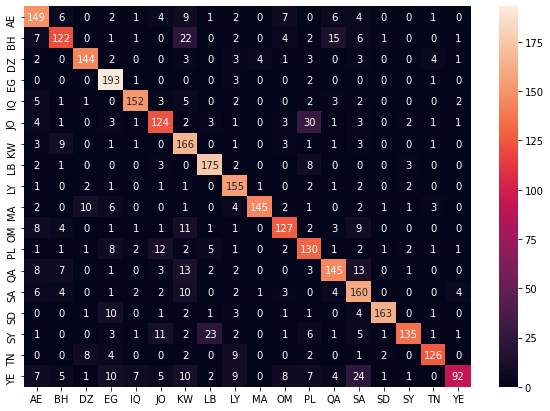

In [ ]:
print(classification_report(dev_df['label'], soft_predictions))
cf_matrix = confusion_matrix(dev_df['label'], soft_predictions)
macro_f1 = f1_score(dev_df['label'], soft_predictions,average='macro')
macro_precision = precision_score(dev_df['label'], soft_predictions,average='macro')
macro_recall = recall_score(dev_df['label'], soft_predictions,average='macro')
acc = accuracy_score(dev_df['label'], soft_predictions)
print("macro f1: " + str(macro_f1))
print("macro precision: " + str(macro_precision))
print("macro recall: " +str(macro_recall))
print("accuracy: " +str(acc))
import seaborn as sns
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cf_matrix, index = ["AE","BH","DZ","EG","IQ","JO","KW","LB","LY","MA","OM","PL","QA","SA","SD","SY","TN","YE"],
                  columns = ["AE","BH","DZ","EG","IQ","JO","KW","LB","LY","MA","OM","PL","QA","SA","SD","SY","TN","YE"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g' )

In [ ]:
# np.savetxt("/content/drive/MyDrive/nlp_models/model.csv", predicted, delimiter=",")

NameError: ignored

In [ ]:
index = 0
mlp = [mlp_predictions[index] for index in range(20,30)]
base = [base_predictions[index] for index in range(20,30)]
medium = [medium_predictions[index] for index in range(20,30)]
soft =  [soft_predictions[index] for index in range(20,30)]
test = [dev_df['label'][index] for index in range(20,30)]
text = [dev_df['text'][index] for index in range(20,30)]
print(mlp)
print(base)
print(medium)
print(soft)
print(test)
print(text)

[0, 0, 9, 5, 6, 14, 7, 6, 9, 4]
[0, 0, 6, 5, 6, 14, 15, 6, 12, 4]
[0, 9, 6, 5, 6, 14, 15, 6, 12, 4]
[0, 0, 6, 5, 6, 14, 15, 6, 12, 4]
[16, 0, 0, 13, 5, 6, 14, 15, 6, 12]
['ال+ دفاع فضيح +ه +ه الله ياخذكم', '[مستخدم] و+ في نفس ال+ وقت ما يقعد ساكت و+ يغض ال+ بظر و+ لا ك+ أن +ه في شي غلط قاعد يصير NEWLINE ال+ رجل أتى ل+ روما ل+ ال+ استثمار و+ ليس ل+ كي يرمي فلوس +ه على ال+ فاضي', '[مستخدم] إذا اللي ف+ بالي ف+ مشكور على ال+ تغريد +ة EMOJI', '[مستخدم] طالب ك+ لاتجيب طار +ي ل+ محمد ال+ شلهوب ترى مافي +هم مكفي +هم .', '[مستخدم] رب +ي يبارك ب+ عمر ك+ و+ الف مبارك الك كمان EMOJI NEWLINE فال ك+ ال+ بيرق EMOJI', '[مستخدم] الله ينعم ب+ حالك ياخوي و+ ما علي ك+ زود ، تستاهل ال+ طيب', '[مستخدم] يا حبيب +نا أنا من أشد ال+ معارض +ين ل+ مزمل ، لكن في ناس مرتد +ين عديل و+ لا داسنها و+ كمان ب+ طالبو ب+ تغيير ال+ ديان +ة في ال+ رقم ال+ وطني ، ب+ قت على مزمل ! نحن ما ناس مغفل +ين عشان نصدق أوهام زي دي و+ لو صدق +نا +ها و+ صفق +نا لي +ها ال+ دور حيجيك و+ حيجي +نا ، ال+ شغل +ة كل +ها تصفي +ة حساب +ات ما اكتر